# Pre-process ECGs and Generate-spectogram

In [ ]:
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
from scipy.signal import butter, lfilter
from scipy import signal
import numpy

## Pre-processing

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    '''
    Implement Butterworth BandPass Filter
    :param lowcut: lower cut of for ecg
    :param highcut: higher cutoff for ecg
    :param fs: sampling rate of the signal
    :param order: order of the filter
    :return: filter factors
    '''
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    '''
    Filter the signal using the BW filter
    :param data: ecg signal
    :param lowcut:
    :param highcut:
    :param fs:
    :param order:
    :return:
    '''
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def de_trend(signal_in):
    '''
    De-Trend a ECG signals window size [1N/8:2N/8]
    :param signal_in: input signal (after bandpass filtering)
    :return: DE-trended signal
    '''
    return signal.detrend(signal_in, bp=[int(len(signal_in) / 8),
                                         int(2*len(signal_in) / 8),
                                         int(3 * len(signal_in) / 8),
                                         int(4 * len(signal_in) / 8),
                                         int(5 * len(signal_in) / 8),
                                         int(6 * len(signal_in) / 8),
                                         int(7 * len(signal_in) / 8),
                                         ])

def smooth(x, window_len=11, window='hanning'):
    '''
    Smooth a given signal
    :param x: signal
    :param window_len: smoothing kernel length
    :param window: window type
    :return: smoothed signal
    '''
    if x.size < window_len:
        raise (ValueError, "Input vector needs to be bigger than window size.")

    if window_len < 3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise (ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s = numpy.r_[x[window_len - 1:0:-1], x, x[-2:-window_len - 1:-1]]
    # print(len(s))
    if window == 'flat':  # moving average
        w = numpy.ones(window_len, 'd')
    else:
        w = eval('numpy.' + window + '(window_len)')

    y = numpy.convolve(w / w.sum(), s, mode='valid')
    return y

def normalize(ecg_signal):
    '''
    Normalize a ECG signal range [0,1]
    :param ecg_signal: pre processed ecg signal
    :return: normalized signal
    '''
    ecg_signal += abs(min(ecg_signal))
    ecg_signal /= max(ecg_signal)

    return ecg_signal

def pre_processing(ecg_signal):
    y_t = butter_bandpass_filter(ecg_signal, 0.05, 100, 1000, order=2)
    signal_de_trend = de_trend(y_t)
    smoothed = smooth(numpy.array(signal_de_trend), window_len=20, window='hamming')[:len(ecg_signal)]
    return normalize(smoothed)

## STFT

In [ ]:
def stft_save_spectogram(pr_ecg, save_file_path_name):
    f, t, Zxx = signal.stft(pr_ecg, fs=1000, nperseg=1000)
    figure(figsize=(256, 256), dpi=1)
    plt.pcolormesh(t, f[:101], numpy.abs(Zxx[:101]), vmin=0, vmax=0.01, shading='gouraud', cmap='jet')
    plt.xticks([], [])
    plt.yticks([], [])
    plt.savefig(save_file_path_name+'.png')

In [ ]:
def compute_stft(pr_ecg):
    f, t, Zxx = signal.stft(pr_ecg, fs=1000, nperseg=1000)
    return Zxx[:101]

## File reading

In [ ]:
def read(file):
    with open(file, 'r') as FP:
        data = [int(x) for x in FP]
    return data

In [ ]:
emotions = ['Neutral','Anxiety', 'Disgust', 'Happy', 'Irritation', 'Relief', 'Sad', 'Surprise']

In [ ]:
DIR_PATH = 'filtered_data_own/'

# listing subject directories
subject_dirs = []
for file in os.listdir(DIR_PATH):
    subject_dirs.append(file)

print(subject_dirs)
print('Number of subject directories : ', len(subject_dirs))

In [ ]:
# listing emotion directories for each subject
subjects_emotions = {}
emotion_dir_count = 0
for sub_dir in subject_dirs:
    emotion_dirs = []
    for file in  os.listdir(DIR_PATH+sub_dir+'/'):
        emotion_dirs.append(file)
    subjects_emotions[sub_dir] = emotion_dirs
    emotion_dir_count = emotion_dir_count+ len(emotion_dirs)

print (subjects_emotions)
print(len(subjects_emotions))
print(emotion_dir_count)

In [ ]:
file_count = {'Neutral': 0,
            'Anxiety': 0,
            'Disgust': 0,
            'Irritation': 0,
            'Sad':0,
            'Surprise':0,
            'Fear':0,
            'Happy': 0,
            'Relief':0}

for subject_dir in subjects_emotions:
    for emotion_dir in subjects_emotions[subject_dir]:
        
        ecg_file_path = DIR_PATH+subject_dir+'/'+emotion_dir+'/'

        ecg_files = sorted(os.listdir(ecg_file_path))   

        file_count[emotion_dir] = file_count[emotion_dir] + len(ecg_files)
        
file_count
            

## Emotion Model

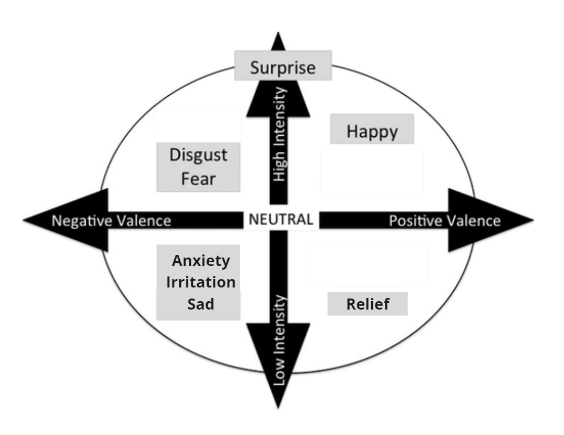

## Valence based data

In [ ]:
emotion_mapping_valence = {'Neutral': 'discard',
                'Anxiety': 'discard',
                'Disgust': 'NEGATIVE',
                'Irritation': 'discard',
                'Sad':'NEGATIVE',
                'Surprise':'discard',
                'Fear':'discard',
                'Happy': 'POSITIVE',
                'Relief': 'POSITIVE'}

In [ ]:
SAVE_DIR_VALENCE = 'spectograms_valence'


# make directory for save spectograms
if not os.path.exists(SAVE_DIR_VALENCE):
    os.makedirs(SAVE_DIR_VALENCE)

raw_ecg_signals = []
pre_process_signals = []

for subject_dir in subjects_emotions:
    for emotion_dir in subjects_emotions[subject_dir]:
        
        if (emotion_dir == 'Happy' or emotion_dir == 'Relief' or emotion_dir == 'Sad' or emotion_dir == 'Disgust'):
            
            ecg_file_path = DIR_PATH+subject_dir+'/'+emotion_dir+'/'
            ecg_files = sorted(os.listdir(ecg_file_path))   


            for ecg_file in ecg_files:

                signal_ecg = read(ecg_file_path+'/'+str(ecg_file))
                raw_ecg_signals.append((signal_ecg,emotion_mapping_valence[emotion_dir]))

                pre_pr_ecg = pre_processing(signal_ecg)
                pre_process_signals.append((pre_pr_ecg,emotion_mapping_valence[emotion_dir]))

                save_file_path_name = SAVE_DIR_VALENCE+'/'+emotion_mapping_valence[emotion_dir]+'/'+subject_dir+'_'+ emotion_dir+'_'+ecg_file.split('.')[0]

                if not os.path.exists(SAVE_DIR_VALENCE+'/'+emotion_mapping_valence[emotion_dir]):
                    os.makedirs(SAVE_DIR_VALENCE+'/'+emotion_mapping_valence[emotion_dir])

#                 stft_save_spectogram(pre_pr_ecg, save_file_path_name)
            
print(len(raw_ecg_signals))  

## Arousal based Data

In [ ]:
emotion_mapping_arousal = {'Neutral': 'NEUTRAL',
                'Anxiety': 'PASSIVE',
                'Irritation': 'PASSIVE',
                'Sad':'PASSIVE',
                'Relief': 'PASSIVE',
                'Disgust': 'ACTIVE',
                'Surprise':'ACTIVE',
                'Fear':'ACTIVE',
                'Happy': 'ACTIVE',
                }

In [ ]:
SAVE_DIR_AROUSAL = 'spectograms_arousal'

# make directory for save scalograms
if not os.path.exists(SAVE_DIR_AROUSAL):
    os.makedirs(SAVE_DIR_AROUSAL)

raw_ecg_signals = []
pre_process_signals = []
for subject_dir in subjects_emotions:
    for emotion_dir in subjects_emotions[subject_dir]:

        if (emotion_dir != 'Neutral'):
            ecg_file_path = DIR_PATH+subject_dir+'/'+emotion_dir+'/'

            ecg_files = sorted(os.listdir(ecg_file_path))   

            for ecg_file in ecg_files:

                signal_ecg = read(ecg_file_path+'/'+str(ecg_file))
                raw_ecg_signals.append((signal_ecg,emotion_mapping_arousal[emotion_dir]))

                pre_pr_ecg = pre_processing(signal_ecg)
                pre_process_signals.append((pre_pr_ecg,emotion_mapping_arousal[emotion_dir]))

                save_file_path_name = SAVE_DIR_AROUSAL+'/'+emotion_mapping_arousal[emotion_dir]+'/'+subject_dir+'_'+ emotion_dir+'_'+ecg_file.split('.')[0]

                if not os.path.exists(SAVE_DIR_AROUSAL+'/'+emotion_mapping_arousal[emotion_dir]):
                    os.makedirs(SAVE_DIR_AROUSAL+'/'+emotion_mapping_arousal[emotion_dir])

                stft_save_spectogram(pre_pr_ecg, save_file_path_name)
            
print(len(raw_ecg_signals))  

## Nine Emotion Data

In [ ]:
SAVE_DIR_NINE = 'spectograms_nine_emotion'

# make directory for save scalograms
if not os.path.exists(SAVE_DIR_NINE):
    os.makedirs(SAVE_DIR_NINE)

raw_ecg_signals = []
pre_process_signals = []
for subject_dir in subjects_emotions:
    for emotion_dir in subjects_emotions[subject_dir]:

        ecg_file_path = DIR_PATH+subject_dir+'/'+emotion_dir+'/'
            
        ecg_files = sorted(os.listdir(ecg_file_path))   
        
        for ecg_file in ecg_files:

            signal_ecg = read(ecg_file_path+'/'+str(ecg_file))
            raw_ecg_signals.append((signal_ecg,emotion_mapping_arousal[emotion_dir]))
            
            pre_pr_ecg = pre_processing(signal_ecg)
            pre_process_signals.append((pre_pr_ecg,emotion_mapping_arousal[emotion_dir]))
            
            save_file_path_name = SAVE_DIR_NINE+'/'+emotion_dir+'/'+subject_dir+'_'+ emotion_dir+'_'+ecg_file.split('.')[0]
            
            if not os.path.exists(SAVE_DIR_NINE+'/'+emotion_dir):
                os.makedirs(SAVE_DIR_NINE+'/'+emotion_dir)
            
            stft_save_spectogram(pre_pr_ecg, save_file_path_name)
            
print(len(raw_ecg_signals))  

# Dogs

In [ ]:
DIR_PATH = 'filtered_data_Dogs/'

subject_dirs = []
for file in os.listdir(DIR_PATH):
    subject_dirs.append(file)

print(subject_dirs)
print('Number of subject directories : ', len(subject_dirs))

In [ ]:
subjects_emotions = {}
emotion_dir_count = 0
for sub_dir in subject_dirs:
    emotion_dirs = []
    for file in  os.listdir(DIR_PATH+sub_dir+'/'):
        emotion_dirs.append(file)
    subjects_emotions[sub_dir] = emotion_dirs
    emotion_dir_count = emotion_dir_count+ len(emotion_dirs)

print (subjects_emotions)
print(len(subjects_emotions))
print(emotion_dir_count)

In [ ]:
emotion_mapping_dogs = {'neutral': 'discard',
                'positive': 'POSITIVE',
                'negative': 'NEGATIVE' }

In [ ]:
file_count = {'neutral': 0,
                'positive': 0,
                'negative': 0 }

for subject_dir in subjects_emotions:
    for emotion_dir in subjects_emotions[subject_dir]:

        ecg_file_path = DIR_PATH+subject_dir+'/'+emotion_dir+'/'

        ecg_files = sorted(os.listdir(ecg_file_path))   

        file_count[emotion_dir] = file_count[emotion_dir] + len(ecg_files)

file_count

In [ ]:
SAVE_DIR_VALENCE = 'spectograms_dogs'


# make directory for save scalograms
if not os.path.exists(SAVE_DIR_VALENCE):
    os.makedirs(SAVE_DIR_VALENCE)

raw_ecg_signals = []
pre_process_signals = []
for subject_dir in subjects_emotions:
    for emotion_dir in subjects_emotions[subject_dir]:

        if (emotion_dir != 'neutral'):
            ecg_file_path = DIR_PATH+subject_dir+'/'+emotion_dir+'/'

            ecg_files = sorted(os.listdir(ecg_file_path))   

            for ecg_file in ecg_files:
  
                signal_ecg = read(ecg_file_path+'/'+str(ecg_file))
                raw_ecg_signals.append((signal_ecg,emotion_dir))

                pre_pr_ecg = pre_processing(signal_ecg)
                pre_process_signals.append((pre_pr_ecg, emotion_dir))

                save_file_path_name = SAVE_DIR_VALENCE+'/'+ emotion_dir +'/'+subject_dir+'_'+ emotion_dir+'_'+ecg_file.split('.')[0]

                if not os.path.exists(SAVE_DIR_VALENCE+'/'+emotion_dir):
                    os.makedirs(SAVE_DIR_VALENCE+'/'+emotion_dir)

                stft_save_spectogram(pre_pr_ecg, save_file_path_name)
            
print(len(raw_ecg_signals)) 

## STFT spectogram

In [ ]:
figure(figsize=(16, 9), dpi=100)
plt.plot(raw_ecg_signals[8][0], 'b')
plt.grid()
plt.title('Original ECG signal')
plt.tight_layout()
plt.show()

In [ ]:
print(pre_process_signals[1][0])

In [ ]:
figure(figsize=(16, 9), dpi=100)
plt.plot(pre_process_signals[8][0], 'g')
plt.grid()
plt.title('Preprocessed normalized ECG signal')
plt.ylabel('Normalized Value')
plt.xlabel('Time [milliseconds]')
plt.tight_layout()
plt.show()

In [ ]:
f, t, Zxx = signal.stft(pre_process_signals[8][0], fs=1000, nperseg=1000)
figure(figsize=(10, 5), dpi=100)
plt.pcolormesh(t, f[:101], numpy.abs(Zxx[:101]), vmin=0, vmax=0.01, shading='gouraud', cmap='jet')

plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.show()